In [ ]:
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving LRFP.csv to LRFP.csv


In [ ]:
import pandas as pd

# Load the dataset
file_path = '/content/LRFP.csv'  # Replace with your actual file name
data = pd.read_csv(file_path)

# Check the first few rows to ensure the data is loaded properly
data.head()


,Channel1,Channel2,Channel3,Class
0,-0.105469,-0.120605,-0.127930,0
1,-0.111328,-0.128906,-0.126465,0
2,-0.117676,-0.109863,-0.119141,0
3,-0.112793,-0.118164,-0.121094,0
4,-0.112305,-0.120117,-0.127441,0


In [ ]:
data.columns

Index(['Channel1', 'Channel2', 'Channel3', 'Class'], dtype='object')

In [ ]:
# Set the window size for iEMG calculation (1000ms = 1 second = 1000 samples)
window_size = 25  # 1000 samples for a 1-second window

# Define a function to compute features for a single channel:
def compute_channel_features(series, window_size):
    # iEMG: Rolling sum of absolute values
    iEMG = series.abs().rolling(window=window_size).sum()
    # MAV: Rolling mean of absolute values
    MAV = series.abs().rolling(window=window_size).mean()
    # STD: Rolling standard deviation
    STD = series.rolling(window=window_size).std()
    # MF: Mean Frequency using FFT (sampling rate = 1000 Hz)
    def mean_freq(x):
        fft_vals = np.abs(np.fft.rfft(x))
        freqs = np.fft.rfftfreq(len(x), d=1/250)
        return np.sum(freqs * fft_vals) / np.sum(fft_vals) if np.sum(fft_vals) != 0 else 0
    MF = series.rolling(window=window_size).apply(mean_freq, raw=True)
    # RMS: Root Mean Square
    RMS = series.abs().rolling(window=window_size).apply(lambda x: np.sqrt(np.mean(np.square(x))), raw=True)
    # ZC: Zero Crossing Count
    def zero_crossings(x):
        return np.sum(np.abs(np.diff(np.sign(x))) > 0)
    ZC = series.rolling(window=window_size).apply(zero_crossings, raw=True)
    return iEMG, MAV, STD, MF, RMS, ZC

# Compute features for each channel
data['iEMG_Channel1'], data['MAV_Channel1'], data['STD_Channel1'], data['MF_Channel1'], data['RMS_Channel1'], data['ZC_Channel1'] = compute_channel_features(data['Channel1'], window_size)
data['iEMG_Channel2'], data['MAV_Channel2'], data['STD_Channel2'], data['MF_Channel2'], data['RMS_Channel2'], data['ZC_Channel2'] = compute_channel_features(data['Channel2'], window_size)
data['iEMG_Channel3'], data['MAV_Channel3'], data['STD_Channel3'], data['MF_Channel3'], data['RMS_Channel3'], data['ZC_Channel3'] = compute_channel_features(data['Channel3'], window_size)

# Drop rows with NaN values created by the rolling window
data = data.dropna()

# Prepare features and labels.
# We now have 18 features: 6 per channel for 3 channels.
feature_columns = [
    'iEMG_Channel1', 'MAV_Channel1', 'STD_Channel1', 'MF_Channel1', 'RMS_Channel1', 'ZC_Channel1',
    'iEMG_Channel2', 'MAV_Channel2', 'STD_Channel2', 'MF_Channel2', 'RMS_Channel2', 'ZC_Channel2',
    'iEMG_Channel3', 'MAV_Channel3', 'STD_Channel3', 'MF_Channel3', 'RMS_Channel3', 'ZC_Channel3'
]

In [ ]:
# Step 3.1: Prepare features and labels
# Features: iEMG values from all three channels
X = data[feature_columns].values

# Labels: The gesture classes (assuming 'Class' is the label column)
y = data['Class'].values


In [ ]:
from sklearn.preprocessing import StandardScaler
import joblib

# Step 3.2: Standardize the features (iEMG values)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
joblib.dump(scaler, 'scaler.pkl')  # Save the fitted scaler


['scaler.pkl']

In [ ]:
from sklearn.model_selection import train_test_split

# Step 3.3: Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Check the shapes of the resulting sets
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(110676, 18) (27670, 18) (110676,) (27670,)


In [ ]:
print(X_train, X_test)
print(y_train, y_test)

[[-0.18231445 -0.18231445 -0.68546655 ...  0.24884125 -0.03060206
   0.67728909]
 [ 0.09343751  0.09343751 -0.53252384 ...  1.62184245  1.91948429
   0.67728909]
 [ 0.10338267  0.10338267  0.31229652 ... -1.20914257 -0.28251289
  -0.50020458]
 ...
 [ 0.15130021  0.15130021  0.27890317 ... -0.04520372 -0.31898672
  -0.50020458]
 [-0.44721714 -0.44721714 -0.72599152 ... -0.27364553 -0.55218292
  -0.50020458]
 [-0.36132719 -0.36132719 -0.70885929 ... -0.47115219 -0.60752577
  -0.50020458]] [[-0.20853348 -0.20853348 -0.31092622 ...  1.22357372  2.12280985
   1.85478276]
 [-0.2691085  -0.2691085  -0.74136862 ...  0.03718871 -0.49291638
  -0.50020458]
 [-0.51683321 -0.51683321 -0.49480941 ...  1.24960065  0.63486065
   2.14915618]
 ...
 [ 0.22543681  0.22543681 -0.80283222 ... -0.72277603 -0.5704108
  -0.50020458]
 [-1.13614497 -1.13614497  0.01167434 ...  0.22043564 -1.04215936
  -0.50020458]
 [ 0.07083489  0.07083489 -0.56263841 ...  1.74103028  0.66859735
   2.44352959]]
[1 1 0 ... 2 3 3]

In [ ]:
# Define the updated model architecture
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Step 4.1: Define the model architecture
model = Sequential([
    Dense(32, input_dim=18, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(4, activation='softmax')  # 5 gesture classes
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 32)                  │             608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,796 (7.02 KB)

 Trainable params: 1,796 (7.02 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Step 4.2: Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")


Epoch 1/10
3459/3459 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8960 - loss: 0.3036 - val_accuracy: 0.9740 - val_loss: 0.0803
Epoch 2/10
3459/3459 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9706 - loss: 0.0889 - val_accuracy: 0.9780 - val_loss: 0.0675
Epoch 3/10
3459/3459 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9738 - loss: 0.0785 - val_accuracy: 0.9799 - val_loss: 0.0630
Epoch 4/10
3459/3459 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9751 - loss: 0.0714 - val_accuracy: 0.9802 - val_loss: 0.0605
Epoch 5/10
3459/3459 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9754 - loss: 0.0695 - val_accuracy: 0.9815 - val_loss: 0.0562
Epoch 6/10
3459/3459 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9771 - loss: 0.0663 - val_accuracy: 0.9826 - val_loss: 0.0542
Epoch 7/10
3459/3459 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9780 - loss: 0.0638 - val_accuracy: 0.9809 - val_loss: 0.0524
Epoch 8/10
3459/3459 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9777 - loss: 0.0

In [ ]:
import tensorflow as tf
tf.keras.backend.clear_session()


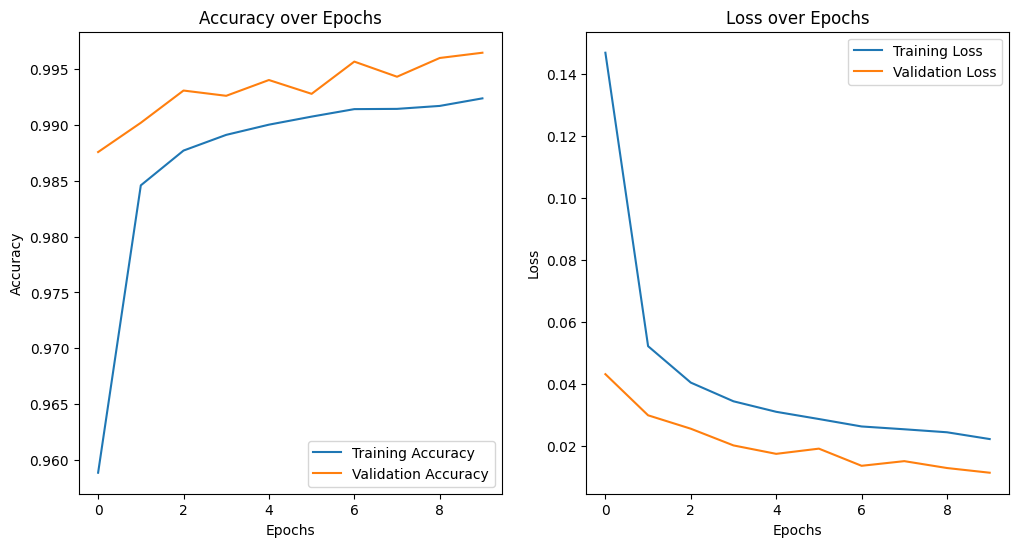

In [ ]:
import matplotlib.pyplot as plt

# Step 4.3: Plot training and validation accuracy and loss
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [ ]:
# Step 5.1: Evaluate the model on the test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")


1063/1063 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9969 - loss: 0.0109
Test Loss: 0.011492373421788216
Test Accuracy: 0.9964405298233032


In [ ]:
import numpy as np

# Step 5.2: Make predictions on the test data
predictions = model.predict(X_test)

# Convert predictions from probabilities to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Print the first few predicted classes to verify
print(predicted_classes[:10])


1063/1063 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
[0 2 3 4 1 3 4 0 3 4]


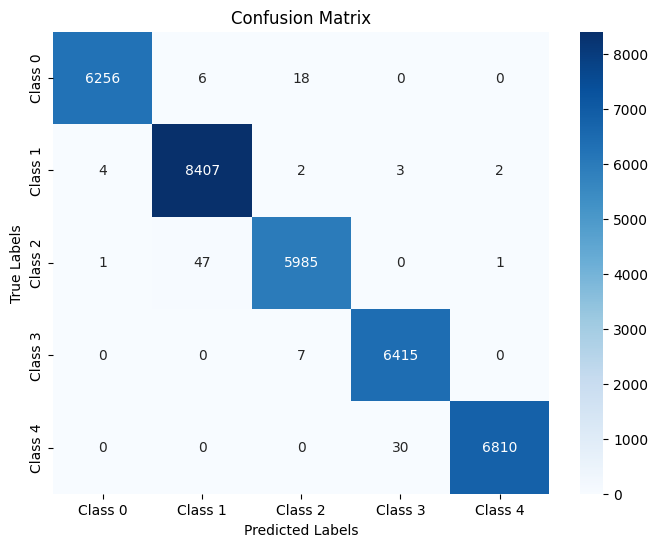

In [ ]:
# Step 5.3: Plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(y_test, predicted_classes)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'], yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [ ]:
# Step 5.4: Print classification report
from sklearn.metrics import classification_report

print(classification_report(y_test, predicted_classes))


              precision    recall  f1-score   support

           0       0.56      0.90      0.69      2958
           1       0.91      0.77      0.84      2924
           2       0.94      0.83      0.88      3088
           3       0.87      0.68      0.76      3026
           4       0.86      0.74      0.80      3053
           5       0.86      0.90      0.88      2927

    accuracy                           0.80     17976
   macro avg       0.83      0.80      0.81     17976
weighted avg       0.83      0.80      0.81     17976



In [ ]:
model.save('model7.2.h5')  # Saves the model to an HDF5 file
